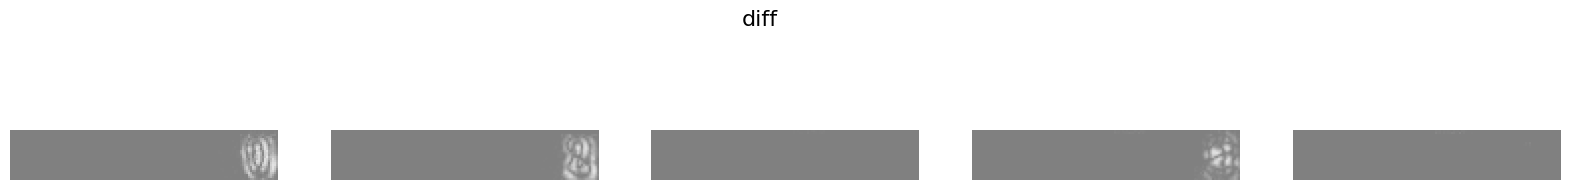

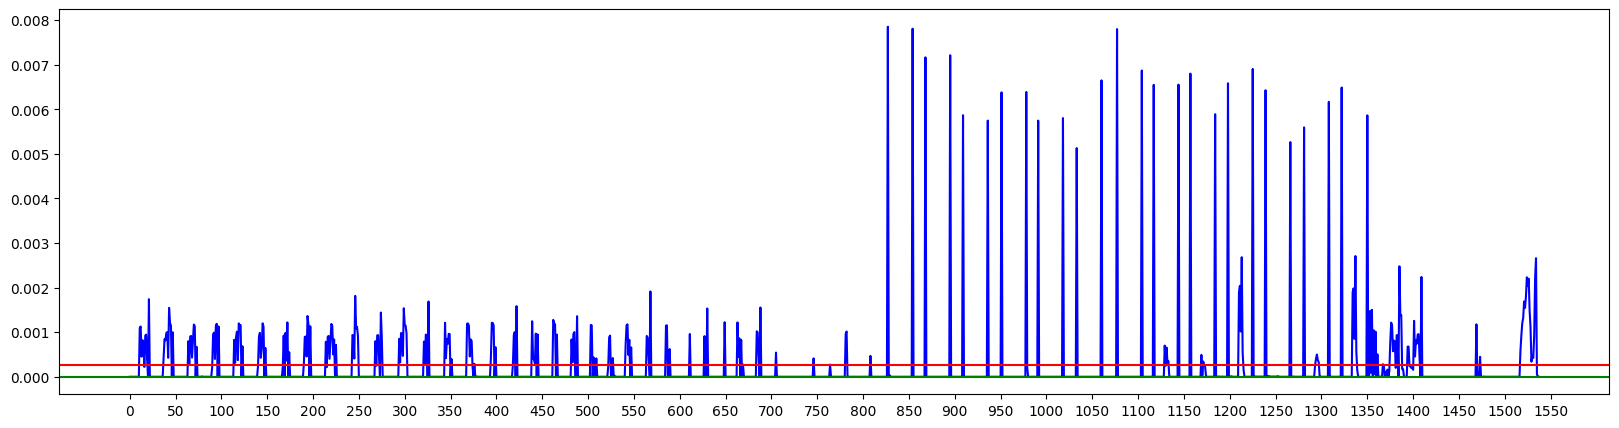

[827, 868, 909, 951, 991, 1033, 1077, 1117, 1157, 1198, 1239, 1281, 1322]
13


In [6]:
# ぷよを消したタイミングのフレームを取得する

from os import major
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from FieldRecognition import FieldRecognition

# 動画読み込み
cap = cv2.VideoCapture("./resources/puyo_battle.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
sec = frame_count / fps

frame_st = 120
frame_ed = 125

# 動画から画像を抽出
frames = []
while True:
    # generator にしたほうが使いやすい
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

# ツモ部分のみ抽出
point_frames = []
for frame in frames:
    point_frames.append(frame[310: 335, 105: 239])

# グレースケール変換
gray_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in point_frames]
gray_frame_range = gray_frames[frame_st:frame_ed]
gray_frame_range2 = gray_frames[frame_st+1:frame_ed+ 1]

# フレーム間の差分を求める。
for bef, aft in zip(gray_frame_range, gray_frame_range2):
    diff_frame = cv2.absdiff(aft, bef)

# 差分出力
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for bef, aft, ax in zip(gray_frame_range, gray_frame_range2, axes):
    diff_frame = cv2.absdiff(aft, bef)
    ax.imshow(diff_frame, cmap="gray", vmin=-255, vmax=255)
    ax.axis("off")

_ = fig.suptitle("diff", fontsize=16)


# 全フレームの差分を計算
diff_frames = [cv2.absdiff(aft, bef) for bef, aft in zip(gray_frames, gray_frames[1:])]
# 2値化して計算しやすくする。
th = 40 # しきい値
for i, x in enumerate(diff_frames):
    x[x < th] = 0
    x[x >= th] = 1
    diff_frames[i] = x
n_diff_pixels = (diff_frames[0] != 0).sum()

fig = plt.figure(figsize=(20, 5))
area = w * h # １フレームのピクセル数
# フレーム間の変化率を計算 
# ※１フレームのピクセル数と「２値化した変化ピクセル？」から変化率を求める
# Maxは1, Minは0
diff_rates = np.array([(d != 0).sum() / area for d in diff_frames])

# 変化率の平均
mean = diff_rates.mean()
# 変化率の中央値
median = np.median(diff_rates)

plt.plot(diff_rates, color="blue", label="rate")
plt.axhline(mean, color="red", label="avg")
_ = plt.axhline(median, color="green", label="median")

ax=plt.gca()
# 数字が表示される目盛り
ax.set_xticks(np.arange(0, 1600, 50))
# サブ目盛り
# ax.set_xticks(np.arange(0, 1600, 25), minor=True)

plt.show()

# 連鎖と関係のない変化率を消す
change_frames = []
for i, diff_rate in enumerate(diff_rates):
    frame_no = i
    if diff_rate > 0.0035:
        change_frames.append(frame_no)

chain_frame = []
a = 0
for i, change_frame in enumerate(change_frames):
    if i >= a:
        chain_frame.append(change_frame)
        a = i + 2
        

print(chain_frame)
print(len(chain_frame))
